In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
! pip install eciespy

In [ ]:
! pip install qrcode

In [4]:
! pip install eth_keys

In [27]:
! pip install base58

In [ ]:
! ls images

# Private Keys, Public Keys and Addresses

<br></br>
<div>
<img src="images/prv_pub_addr.png" width="800"/>
</div>

In order to play the cryptocurrency game we need to be able to manage private keys, public keys and addresses.

- **private key** you know from asymmetric cryptography. We are using ECC and the Secp256k1 curve. This is made of 256 bits of entropy. 
- **public key** you know from asymmetric cryptography. This key is derived from the private key.
- **address** is a series of hashes of the public key and base58 encoding.

LINKS:
- https://en.bitcoin.it/wiki/Secp256k1
- https://en.bitcoin.it/wiki/Wallet_import_format
- https://en.bitcoin.it/wiki/Technical_background_of_version_1_Bitcoin_addresses
- https://en.bitcoin.it/wiki/Base58Check_encoding

# Imports and Definitions

In [2]:
import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
def save_privkey(privkey,privkey_filepath,password=None):
    if password==None:
        while True:
                password = getpass.getpass("Input password for encrypting keyfile: ")
                password_2 = getpass.getpass("Repeat password for encrypting keyfile: ")
                if password==password_2:
                    print('\nPasswords match...')
                    break
                else:
                    print('\nPasswords do not match...')
    encrypted_bytes=ecies.aes_encrypt(key=hashlib.sha256(password.encode()).digest(),
                                      plain_text=privkey.to_bytes())
    open(privkey_filepath,'wb').write(encrypted_bytes)
    print(f'Password protected file written to {privkey_filepath} containing {encrypted_bytes.hex()}')
    
def save_pubkey(pubkey,pubkey_filepath):
    open(pubkey_filepath,'wb').write(pubkey.to_bytes())
    print(f'File written to {pubkey_filepath} containing {pubkey.to_bytes().hex()}')
    
def save_addr(addr,addr_filepath):
    open(addr_filepath,'wb').write(addr.encode())
    print(f'Address written to {addr_filepath} containing {addr}')

def make_qr(data,image_path=None):
    qr = qrcode.QRCode(version=1,box_size=5,border=2)
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill='black', back_color='white')
    if image_path!=None:
        img.save(image_path)
    return img
    
def gen_save_keys_addr(basename_filepath,password=None):
    if os.path.isfile(basename_filepath+'_prv.enc'):
        privkey2save=import_privKey(basename_filepath+'_prv.enc',password)
    else:
        privkey2save = ecies.utils.generate_eth_key()
    pubkey2save = privkey2save.public_key
    doge = cryptos.Doge()
    addr2save=doge.pubtoaddr('04'+pubkey2save.to_bytes().hex())    
    save_privkey(privkey2save,basename_filepath+'_prv.enc',password=password)
    save_pubkey(pubkey2save,basename_filepath+'_pub.bin')
    save_addr(addr2save,basename_filepath+'_addr.bin')
    return make_qr(addr2save,basename_filepath+'_addr.png')
    
def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

# Making Private, Public and Address Files

In [6]:
! mkdir keys

Password protected file written to keys/my_prv.enc containing a41d4c048f7c5205f6bac7609da4cc38c5760850176780460a94de248f7ee201cf04dbcb75fab6b42ba9ea9541731c88b2661119872cf7797195e3561e39a76b
File written to keys/my_pub.bin containing 0938514de4e0a2a4c9f3eda196741a6d68523b239e95ed253fa19bd65479c69fbbe22d8bda611de5e52d29b67cf5106297b701b295a2958c2295468d2994cd7e
Address written to keys/my_addr.bin containing DDLGhb7pd4Vxdqz6fW77SYHmKRHokq7Xdp


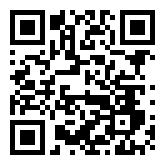

In [7]:
gen_save_keys_addr('keys/my',password='')

In [8]:
privKey=import_privKey('keys/my_prv.enc','')
privKey,type(privKey)

('0x864001237a01058fdc9be00564b7cf9ddd59ab03efafa37373f56fdbf8412556',
 eth_keys.datatypes.PrivateKey)

In [9]:
pubKey=import_pubKey('keys/my_pub.bin')
pubKey,type(pubKey)

('0x0938514de4e0a2a4c9f3eda196741a6d68523b239e95ed253fa19bd65479c69fbbe22d8bda611de5e52d29b67cf5106297b701b295a2958c2295468d2994cd7e',
 eth_keys.datatypes.PublicKey)

In [10]:
addr=import_addr('keys/my_addr.bin')
addr

'DDLGhb7pd4Vxdqz6fW77SYHmKRHokq7Xdp'

# Address Generation Details

<div>
<img src="images/PubKeyToAddr.png" width="300"/>
</div>

If we wanted to do the address generation by hand, it would go as follows.

1) Start with the **PUBLIC KEY** prepended with byte **`04`**

In [11]:
pbkey04='04'+pubKey.to_hex()[2:]
pbkey04

'040938514de4e0a2a4c9f3eda196741a6d68523b239e95ed253fa19bd65479c69fbbe22d8bda611de5e52d29b67cf5106297b701b295a2958c2295468d2994cd7e'

2) Next apply the **`HASH160`**. Remember this is **`SHA256`** hashing followed by **`RIPMED160`** hashing.

In [12]:
cryptos.bin_hash160(bytes.fromhex(pbkey04)).hex()

'59de104fe71ad31812da1f05b58a27103598e6bb'

In [13]:
pbkey_160=cryptos.hex_to_hash160(pbkey04)
pbkey_160

'59de104fe71ad31812da1f05b58a27103598e6bb'

3) Then prepend the **magic byte** to the **`HASH160`** output.

In [14]:
doge=cryptos.Doge()
magic=hex(doge.magicbyte)
magic_pbkey_160=magic[2:]+pbkey_160
magic

'0x1e'

4) Take a detour and complete the side project taking the **DOUBLE SHA256** of the previous output. The **first 4 bytes** of this will be the **checksum**. Appending this suffix to the previous output will yield the address in bytes/hex.

In [15]:
suffix=cryptos.dbl_sha256(bytes.fromhex(magic_pbkey_160))[:8]

In [16]:
hex_addr=magic_pbkey_160+suffix
hex_addr

'1e59de104fe71ad31812da1f05b58a27103598e6bb870ed7df'

The above yields a legit address though we generally take the additional step of doing a base58 encoding.

5) Finally we do a **base58** encoding. Note the magic byte prefix of Dogecoin **`0x1e`** ensures the base58 address will always start with a **`D`**

In [17]:
base58.b58encode(bytes.fromhex(hex_addr)).decode()

'DDLGhb7pd4Vxdqz6fW77SYHmKRHokq7Xdp'

In [18]:
addr

'DDLGhb7pd4Vxdqz6fW77SYHmKRHokq7Xdp'

# WIF

Wallet Import Format (WIF) is the base58 encoding for private keys. It is worth going over as an exercize.

1) Start with a **PRIVATE KEY** and prepend the network specific byte. `0x80` for Bitcoin and `0x9e` for Dogecoin.

In [19]:
prvkey=privKey.to_hex()[2:]
prvkey

'864001237a01058fdc9be00564b7cf9ddd59ab03efafa37373f56fdbf8412556'

In [20]:
prvkey9e='9e'+prvkey
prvkey9e

'9e864001237a01058fdc9be00564b7cf9ddd59ab03efafa37373f56fdbf8412556'

2) The second step is to **DOUBLE SHA256** the prepended private key. The **first 4 bytes** of the output provide the **checksum suffix**.

In [21]:
wif_checksum = cryptos.dbl_sha256(bytes.fromhex(prvkey9e))[:8]
wif_checksum

'2353e483'

3) Lastly we append the suffix to the private key and encode using base58.

In [22]:
prvkey9e_suffixed=prvkey9e+wif_checksum
wif=base58.b58encode(bytes.fromhex(prvkey9e_suffixed)).decode()
wif

'6K9k7MYDwen38GfZN7ty8ME7gtN5jFJdB9PtedCVgjKKokSiUnn'

In [23]:
def to_wif(pvk,prefix='9e'):
    import base58
    import cryptos
    checksum=cryptos.dbl_sha256(bytes.fromhex(prefix+pvk))[:8]
    return base58.b58encode(bytes.fromhex(prefix+pvk+checksum)).decode()

def from_wif(wif):
    return base58.b58decode(wif).hex()[2:-8]

In [24]:
doge_wif=to_wif(privKey.to_hex()[2:])
doge_wif

'6K9k7MYDwen38GfZN7ty8ME7gtN5jFJdB9PtedCVgjKKokSiUnn'

In [25]:
og_prvkey=from_wif(doge_wif)
prvkey , og_prvkey==prvkey

('864001237a01058fdc9be00564b7cf9ddd59ab03efafa37373f56fdbf8412556', True)

# Base58

For creating addresses and WIF private keys, we have been using base58 encodings.

What's so dope about base58?

- Don't want `0OIl` characters that look the same in some fonts and could be used to create visually identical looking strings.
- A string with non-alphanumeric characters is not as easily accepted.

In [26]:
hexstring=prvkey9e_suffixed

code_string = "123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz"
x = int(hexstring,base=16)
output_list = []
   
while(x > 0):
    (remainder,x) = x%58,x//58
    output_list.append(code_string[remainder])

''.join(output_list)[::-1]

'6K9k7MYDwen38GfZN7ty8ME7gtN5jFJdB9PtedCVgjKKokSiUnn'

In [28]:
wif

'6K9k7MYDwen38GfZN7ty8ME7gtN5jFJdB9PtedCVgjKKokSiUnn'